LAPYUTA MRS 感度カーブ (resolved line or continnum)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.constants import * 

# import SPICE user lib
import lappy as laplib

#plt.rcParams["font.size"] = 10

@dataclass
class obs:
    tau: float      # integration time [s]
    snr: float      # signal-to-noise ratio
    inst: str       # mrs or hrs
    model: str      # baseline or target
    w: float        # Slit width [arcsec]
    ds: float       # Spatial range of interest [arcsec]
    dl: float       # Spectral range of interest [A]
    

In [2]:
def plot_limit_diffuse_flux(obs, lap, wl, sd_r, n_cr, wl_range=[1100,1900]):

    I2F = 1.0e6 / (4.0*np.pi) * (1.0/3600.0*np.pi/180.0)**2 * (h*1e7*c)  / (wl*1e-10) # (erg/cm2/s/arcsec2)/R

    row = 1
    col = 2
    fig, ax = plt.subplots(nrows=row, ncols=col,figsize=(12,6))
    fig.suptitle('Limiting flux for '+lap.description+' / S/N='+str(obs.snr)+', ds='+str(obs.ds)+'[asec], dl='+str(obs.dl)+'[$\AA$]', fontsize=16)

    for tau in obs.tau:
        lim_count_d = (1.0 + np.sqrt(1.0 + 4.0*n_cr*tau/obs.snr**2)) * obs.snr**2 / (2.0*tau)
        lim_flux_d = lim_count_d / (sd_r * lap.n_w * lap.n_s)
        if tau>3600*24:
            label=str(tau/3600/24)+'[day]'
        elif tau>3600:
            label=str(tau/3600)+'[hour]'
        else:
            label=str(tau)+'[s]'
        ax[0].plot(wl, lim_flux_d, label=label)
        ax[1].plot(wl, lim_flux_d/I2F, label=label)

    ax[0].set_xlim(wl_range)
    ax[0].set_yscale('log')
    ax[0].legend()
    ax[0].set_title('Diffuse source with w='+str(obs.w)+'[asec]')
    ax[0].set_xlabel('Wavelength [$\AA$]')
    ax[0].set_ylabel('Limiting flux [erg/cm$^{2}$/s/$\AA$]')

    ax[1].set_xlim(wl_range)
    ax[1].set_yscale('log')
    ax[1].legend()
    ax[1].set_title('Diffuse source with w='+str(obs.w)+'[asec]')
    ax[1].set_xlabel('Wavelength [$\AA$]')
    ax[1].set_ylabel('Limiting brightness [Rayleigh/$\AA$]')

Observation parameters

In [ ]:
# Observation parameters
# SNR
obs.snr = 10
# integration time [s]
obs.tau = [3600.0*24.0, 3600.0*24.0*10.0, 3600.0*24.0*100.0]

# Spectrometer
obs.inst = 'mrs'        # 'mrs' or 'hrs'
obs.model = 'baseline'  # 'baseline' or 'target'


if obs.inst == 'mrs':
    # Slit width [arcsec]
    obs.w = 1.0
    # Spatial range of interest [arcsec]
    obs.ds = 1.0
    # Spectral range of interest [A] (Plot)
    obs.dl = 10.0
elif obs.inst == 'hrs':
    # Slit width [arcsec]
    obs.w = 1.0
    # Spatial range of interest [arcsec]
    obs.ds = 1.0
    # Spectral range of interest [A] (Plot)
    obs.dl = 0.03

Load LAPYUTA spec

In [4]:
# Load LAPYUTA parameters
lap = laplib.get_lap_spec(inst=obs.inst, model=obs.model)
[wl, lap_ae] = laplib.get_lap_ae(inst=obs.inst, model=obs.model)

# Number of pixel to integrate
lap.w = obs.w 
lap.n_w = round(obs.dl/lap.d)
lap.n_s = round(obs.ds/lap.m)

Get sensitivity

In [5]:
# Sensitivity
#   For point     & resolved source    (sp_r) [(counts/s/pix)   / (erg/cm^2/s/A)]
#   For diffusive & resolved source    (sd_r) [(counts/s/pix^2) / (erg/cm2/s/A/arcsec^2)]
#   For point     & un-resolved source (sp_u) [(counts/s/pix)   / (erg/cm^2/s)]
#   For diffusive & un-resolved source (sd_u) [(counts/s/pix^2) / (erg/cm2/s/arcsec^2)]
# LAPYUTA
[sp_r, sd_r] = laplib.get_sensitivity(lap, lap_ae, wl, resolved=1)
[sp_u, sd_u] = laplib.get_sensitivity(lap, lap_ae, wl, resolved=0)

Plot sensitivity

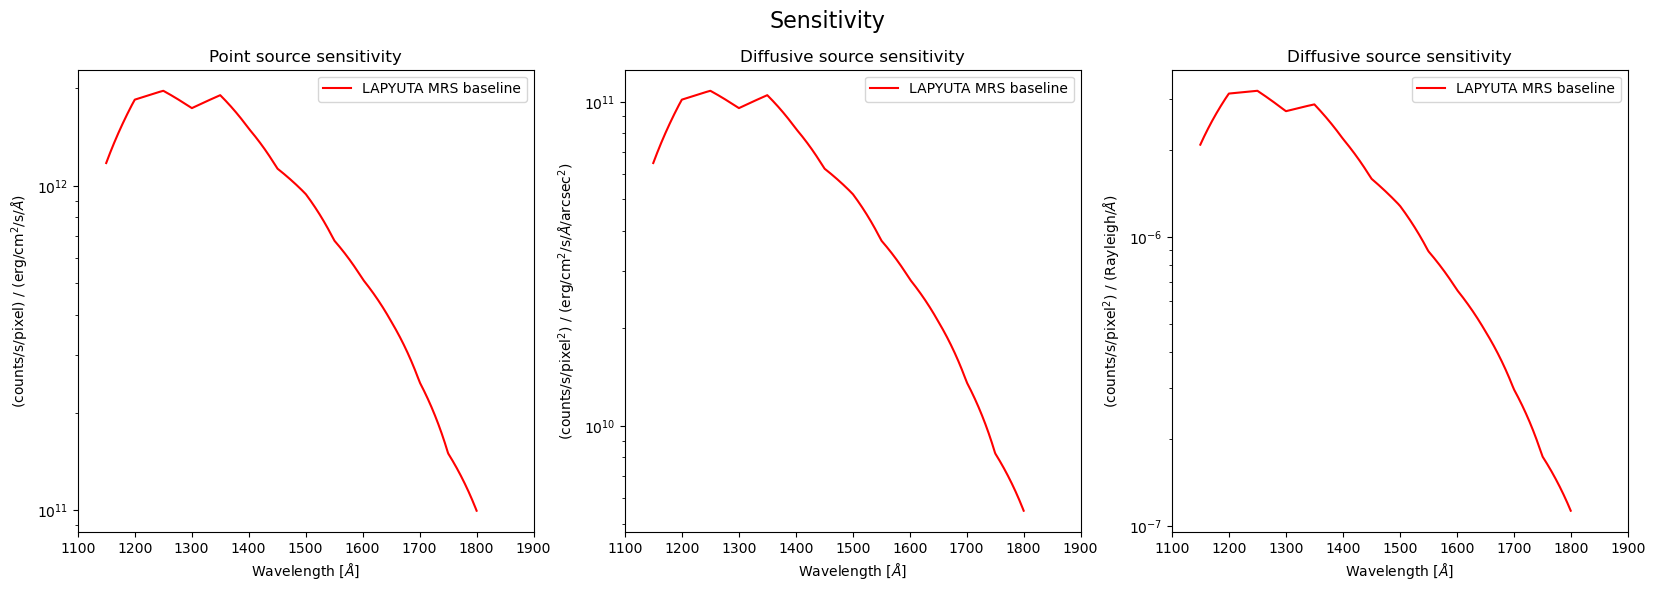

In [6]:
row = 1
col = 3
fig, ax = plt.subplots(nrows=row, ncols=col,figsize=(20,6))
fig.suptitle("Sensitivity", fontsize=16)

#-------------------------------------------------
# For point source (Sp/d)
#-------------------------------------------------
ax[0].plot(wl, sp_r, 'r-', label=lap.description)
ax[0].set_ylabel('(counts/s/pixel) / (erg/cm$^{2}$/s/$\AA$)')

ax[0].set_yscale('log')
ax[0].set_xlim([1100,1900])
ax[0].set_title('Point source sensitivity')
ax[0].set_xlabel('Wavelength [$\AA$]')
ax[0].legend()

#-------------------------------------------------
# For diffusive source Sd
#-------------------------------------------------
ax[1].plot(wl, sd_r, 'r-', label=lap.description)
ax[1].set_ylabel('(counts/s/pixel$^{2}$) / (erg/cm$^{2}$/s/$\AA$/arcsec$^{2}$)')

ax[1].set_yscale('log')
ax[1].set_xlim([1100,1900])
ax[1].set_title('Diffusive source sensitivity')
ax[1].set_xlabel('Wavelength [$\AA$]')
ax[1].legend()

#-------------------------------------------------
# For diffusive source Sd (in R unit)
#-------------------------------------------------
I2F = 1.0e6 / (4.0*np.pi) * (1.0/3600.0*np.pi/180.0)**2 * (h*1e7*c)  / (wl*1e-10) # (erg/cm2/s/arcsec2)/R
ax[2].plot(wl, sd_r*I2F, 'r-', label=lap.description)
ax[2].set_ylabel('(counts/s/pixel$^{2}$) / (Rayleigh/$\AA$)')

ax[2].set_yscale('log')
ax[2].set_xlim([1100,1900])
ax[2].set_title('Diffusive source sensitivity')
ax[2].set_xlabel('Wavelength [$\AA$]')
ax[2].legend()

Count rate $C_{n}$

In [7]:
d_wl = wl[1]-wl[0]

# 装置関数の畳み込み
ild = lap.d / lap.m     # 逆線分散(ild): スリット面上での単位長さあたりの波長幅。逆線分散xスリット幅~波長分解の指標
sgm = ild * lap.w
nw_ = int(80.0 / d_wl)
wl_ = np.linspace(-40.0, 40.0, nw_)
I_inst = laplib.line_profile(1.0, 0.0, sgm, wl_) * d_wl  # sum of I_inst = 1

# 波長方向平均の畳み込み
nw_ = int(obs.dl / d_wl)
wl_ = np.linspace(-float(nw_)/2.0, float(nw_)/2.0, nw_)
I_mean = np.ones(nw_)/float(nw_)  # sum of I_mean = 1

# Geocorona
I_gc_src = laplib.get_geocorona(lap.I_Lya, lap.I_1304, lap.I_1356, wl)
I_gc_tmp = np.convolve(I_gc_src, I_inst, mode = 'same')
I_gc     = np.convolve(I_gc_tmp, I_mean, mode = 'same')
n_cr_gc = I_gc * sd_r * lap.n_s * lap.n_w  # [counts/s]

# Detector noise + Geocorona
n_cr_min = (lap.cr_d_min + lap.cr_r_min) * lap.n_s * lap.n_w + n_cr_gc # [counts/s]
n_cr_max = (lap.cr_d_max + lap.cr_r_max) * lap.n_s * lap.n_w + n_cr_gc # [counts/s]
n_cr = n_cr_min

Plot Limiting flux

where $C_{s} = SNR \sqrt{C_{s} + C_{n}}$

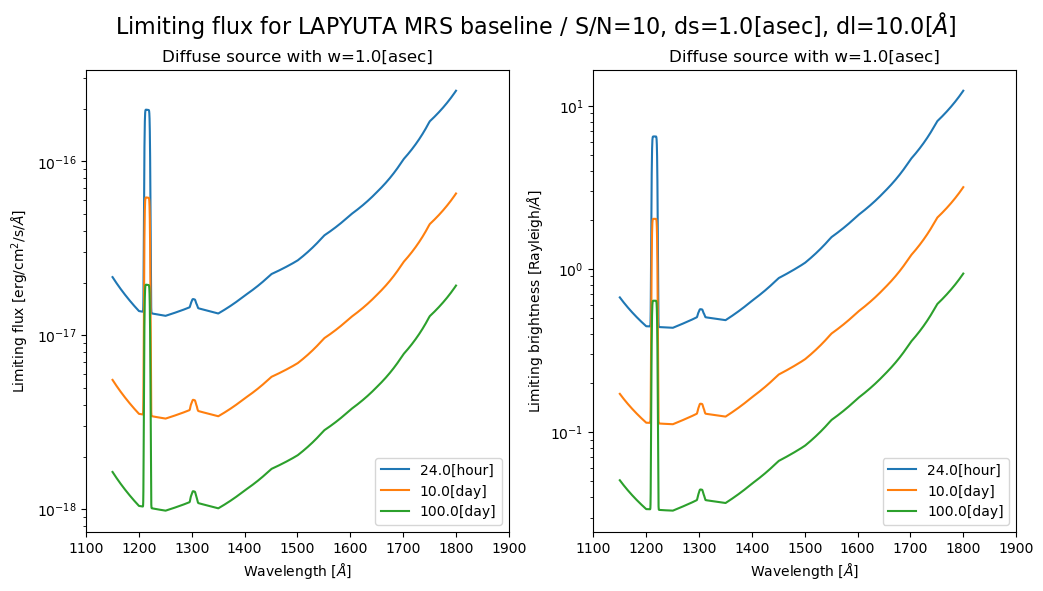

In [8]:
wl_range = [1100,1900]
plot_limit_diffuse_flux(obs, lap, wl, sd_r, n_cr, wl_range)

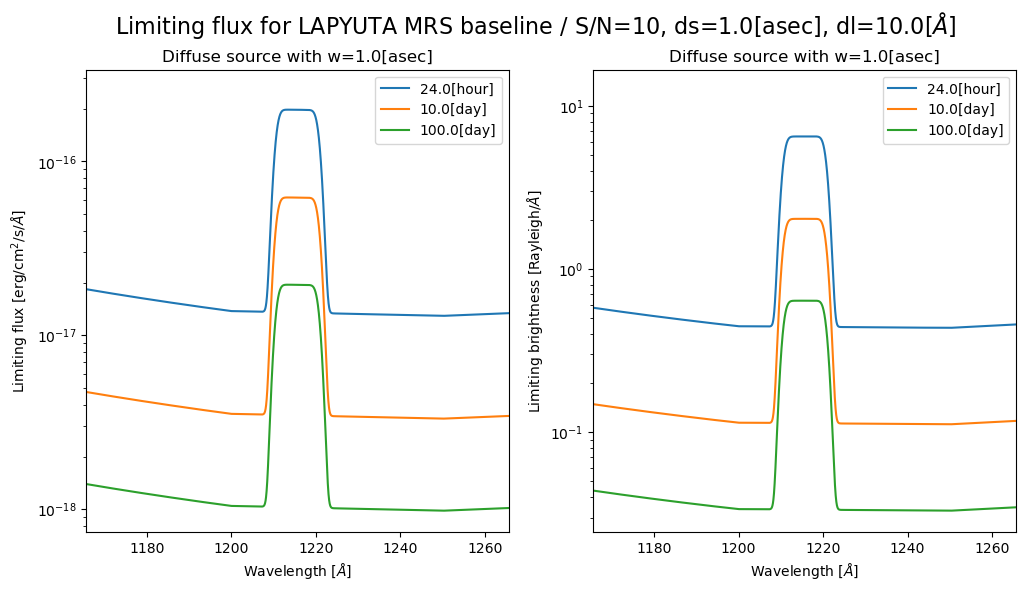

In [9]:
if obs.inst == 'mrs': wl_range = [1215.67-obs.dl*5,1215.67+obs.dl*5]
if obs.inst == 'hrs': wl_range = [1215.67-obs.dl*30,1215.67+obs.dl*30]

plot_limit_diffuse_flux(obs, lap, wl, sd_r, n_cr, wl_range)

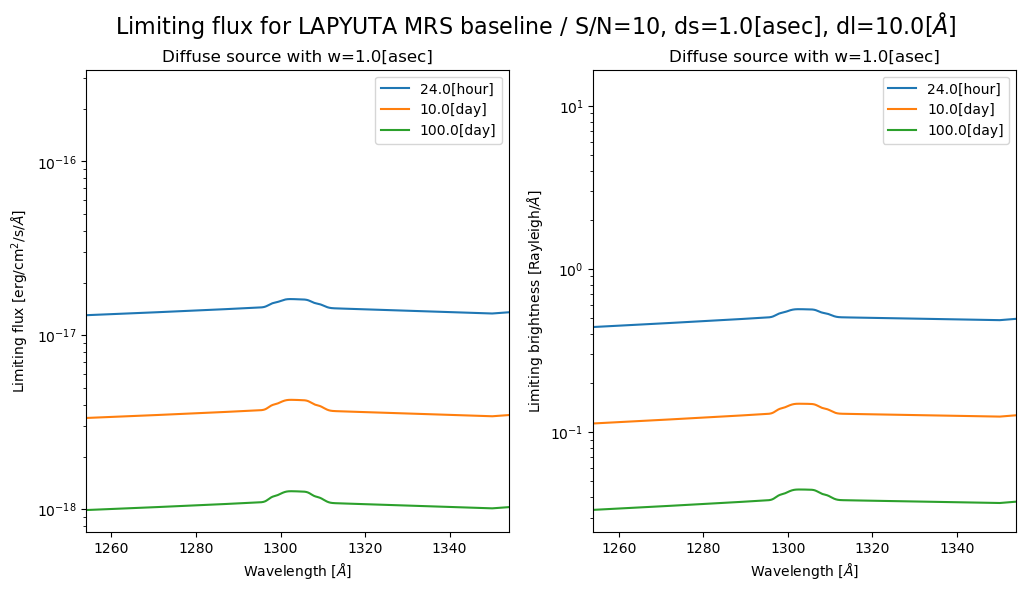

In [10]:
if obs.inst == 'mrs': wl_range = [1304-obs.dl*5,1304+obs.dl*5]
if obs.inst == 'hrs': wl_range = [1304-obs.dl*100,1304+obs.dl*100]
plot_limit_diffuse_flux(obs, lap, wl, sd_r, n_cr, wl_range)